In [1]:
# Modules

import numpy as np
import scipy.integrate as spint
import scipy.stats as spstat
import matplotlib.pyplot as plt

#import argparse

from joblib import Parallel, delayed

from dataclasses import dataclass

import os
os.environ['MKL_NUM_THREADS'] = '4'

In [2]:
# Class for the CANN model

class cann_model:
    # define the range of perferred stimuli
    z_min = - np.pi;              
    z_range = 2.0 * np.pi;
    # define the time scale
    tau = 2.0
        
    # function for periodic boundary condition
    def dist(self, c):
        tmp = np.remainder(c, self.z_range)
        
        # routine for numbers
        if isinstance(tmp, (int, float)):
            if tmp > (0.5 * self.z_range):
                return (tmp - self.z_range);
            return tmp;
        
        # routine for numpy arraies
        for tmp_1 in np.nditer(tmp, op_flags=['readwrite']):
            if tmp_1 > (0.5 * self.z_range):
                tmp_1[...] = tmp_1 - self.z_range;
        
        return tmp;
    
    # constructor (?)
    def __init__(self, argument):
        self.k = argument.k;              # rescaled inhibition
        self.beta = argument.beta;        # rescaled STD
        self.beta_f = argument.beta_f;    # flat STD ?
        self.case = argument.case
        self.taud = argument.taud;        # rescaled STD timescale
        self.a = argument.a;              # range of excitatory connection
        self.N = argument.N;              # number of units / neurons
        self.dx = self.z_range / self.N     # separation between neurons
        
        # define perferred stimuli for each neuron
        self.x = (np.arange(0,self.N,1)+0.5) * self.dx + self.z_min;
        
        # difference of x's
        self.x_diff = np.array(
                       [[self.dist(self.x[i] - self.x[j]) 
                         for j in range(self.x.shape[0])]
                        for i in range(self.x.shape[0])]
                       )
        
        # calculate the excitatory couple for each pair of neurons
        self.Jxx = np.exp(-0.5 * np.square(
                      self.x_diff / self.a
                   ) ) / (np.sqrt(2*np.pi) * self.a);
                
        self.y = np.zeros((self.N + self.N * self.N));   # initialize dynamical variables
        self.y[self.N:] = 1.0
        
        
        
        if self.beta_f:
            self.beta = argument.beta
        else:
            self.beta = np.zeros_like(self.x_diff)
            
            for i in np.arange(self.Jxx.shape[1]):
                
                local_x = np.abs(self.x_diff[:,i])
                
                x_max = np.max(local_x) + (self.z_range/self.N) / 2.0
                x_min = np.min(local_x) - (self.z_range/self.N) / 2.0
                
                ps = (x_max - local_x) / (x_max - x_min)
                
                if self.case > 0:
                    gamma_randm = spstat.gamma.ppf(ps, 3.354520641938138)*9.743699331037247
                else:
                    gamma_randm = spstat.gamma.ppf(ps, 1.377771974410986)*29.196273404252505
                    
                self.beta[:,i] = gamma_randm.transpose()
            
            self.beta *= argument.beta / np.mean(self.beta)
                             
                    
        # Here the first N y elements for u(x,t)
        # and the last N*N elements for p(x,x',t)
        
        self.r = np.zeros((self.N));                     # initialize neuronal activities
        self.input = np.zeros((self.N))                  # initialial the external input
        self.noise = np.zeros((self.N))                  # initialize the noise
    
    # function for setting external iput for each neuron
    def set_input(self, A, z0):
        self.input = \
        A * np.exp(-0.25 * np.square(self.dist(self.x - z0) / self.a));
    
    # function for calculation of neuronal activity of each neuron
    def cal_r_or_u(self, u_in):
        
        if (u_in.shape[0] > self.N):
            u = u_in[:self.N]
        else:
            u = u_in
            
        u0 = 0.5 * (u + np.abs(u));
        r = np.square(u0);
        B = 1.0 + 0.125 * self.k * np.sum(r) * self.dx \
        / (np.sqrt(2*np.pi) * self.a);
        r = r / B;
        
        return r;
    
    # Calculate the centre of mass of u(x,t)
    def cm_of_u(self):
        u = self.y[:self.N]
        max_i = u.argmax()
        cm = np.dot(self.dist(self.x - self.x[max_i]), u) / u.sum()
        cm = cm + self.x[max_i]
        return cm;
    
    # function for calculation of derivatives
    def get_dydt(self, t, y):
        u = y[:self.N]
        p = y[self.N:].reshape((self.N, self.N))
        r = self.cal_r_or_u(u)
        
        dudt = \
            -u + np.dot(self.Jxx* p , r) * self.dx + self.input + self.noise;
        dudt = dudt / self.tau;
        
        dpdt = (1-p - self.beta * p * r) / self.taud
        
        dydt = np.append(dudt, dpdt.reshape(-1))
        
        return dydt

    
    # function for calculation of derivatives
    
    # !! The following function is to force a symmetic environment 
    #    so that the bump can only be static
    
    def get_dydt_sym(self, t, y):
        u = y[:self.N]
        u = 0.5 * (u + u[::-1])
        p = y[self.N:].reshape((self.N, self.N))
        r = self.cal_r_or_u(u)
        
        dudt = \
            -u + np.dot(self.Jxx* p , r) * self.dx + self.input + self.noise;
        dudt = dudt / self.tau;
        
        dpdt = (1-p - self.beta * p * r) / self.taud
        
        dydt = np.append(dudt, dpdt.reshape(-1))
        
        return dydt
    
    # update the noise This function is added to do investigation with noise
    # T is the noise temperature, dt is the size of time steps
    def update_noise(self, T, dt, ng):
        self.noise = ng.normal(size=self.N) * np.sqrt(2.0*T/(self.dx*dt))

In [3]:
# Defining a class of input arguments as a workaround 
# for the argparse

@dataclass()
class argument_c:
    k:float
    beta:float
    beta_f:bool
    case:int
    taud:float
    a:float
    N:int
    
    def _init__(self, N, k, beta, beta_f, case, taud, a, b):
        self.N = N
        self.k = k
        self.beta = beta
        self.case = case
        self.beta_f = beta_f
        self.taud = taud
        self.a = a

In [4]:
    


k_in = 0.5
beta_in = 0.0005

# This function is to generate a single sample for noise response (how much drift generated by noise)
def one_sample(k_in, beta_in, sample_t):
    
    # np.random.seed(sample_t+1)

    ng = np.random.default_rng(seed=sample_t)

    arg1 = argument_c(N=128, k=k_in, beta=beta_in, beta_f=False, case=0, taud=100, a=0.5)
    the_model1 = cann_model(arg1)

    arg2 = argument_c(N=128, k=k_in, beta=beta_in, beta_f=False, case=1, taud=100, a=0.5)
    the_model2 = cann_model(arg2)

    # Initialize the system

    the_model1.set_input(np.sqrt(8.0)/k_in, 0)

    the_model1.y[0:the_model1.N] = the_model1.input            
    the_model2.y[0:the_model2.N] = the_model1.input            

    the_model1.set_input(0, 0)
    the_model2.set_input(0, 0)

    out1 = spint.solve_ivp(the_model1.get_dydt_sym, (0, 1000), the_model1.y, method="RK45");
    out2 = spint.solve_ivp(the_model2.get_dydt_sym, (0, 1000), the_model2.y, method="RK45");

    # update the network state in the CANN object
    the_model1.y = out1.y[:,-1]
    the_model2.y = out2.y[:,-1]

    N = the_model1.N
    N_shift = int(0.67 * N * the_model1.a / (the_model1.x.max() - the_model2.x.min()))
    y_tmp = the_model1.y[0:N]
    the_model1.y[0:N] = np.append(y_tmp[:N_shift], y_tmp[N_shift:])

    N = the_model2.N
    N_shift = int(0.67 * N * the_model2.a / (the_model2.x.max() - the_model2.x.min()))
    y_tmp = the_model2.y[0:N]
    the_model2.y[0:N] = np.append(y_tmp[:N_shift], y_tmp[N_shift:])

    out1 = spint.solve_ivp(the_model1.get_dydt, (0, 20000), the_model1.y, method="RK45");
    out2 = spint.solve_ivp(the_model2.get_dydt, (0, 20000), the_model2.y, method="RK45");

    # update the network state in the CANN object
    the_model1.y = out1.y[:,-1]
    the_model2.y = out2.y[:,-1]

    time_step = 1

    # arrays for snapshots
    snapshots1_z = []
    snapshots2_z = []

    # Sample duration
    t_max = 4000
    
    # create an array for time steps
    ts = np.arange(0, t_max, time_step)

    # run the simulation and take snapshots every time_step
    for t in ts:
        # decide the period of this step
        t0 = t
        t1 = t + time_step
        # update the noise
        the_model1.update_noise(0.01, time_step, ng)
        the_model2.update_noise(0.01, time_step, ng)
        # run the simulation and update the state in the CANN object
        out1 = spint.solve_ivp(the_model1.get_dydt, (t0, t1), the_model1.y, method="RK45")
        the_model1.y = out1.y[:,-1]
        out2 = spint.solve_ivp(the_model2.get_dydt, (t0, t1), the_model2.y, method="RK45")
        the_model2.y = out2.y[:,-1]
        if len(snapshots1_z) < 1:
            snapshots1_z.append(the_model1.cm_of_u())
            snapshots2_z.append(the_model2.cm_of_u())
        else:
            snapshots1_z.append(snapshots1_z[-1]+the_model1.dist(the_model1.cm_of_u()-snapshots1_z[-1]))
            snapshots2_z.append(snapshots2_z[-1]+the_model2.dist(the_model2.cm_of_u()-snapshots2_z[-1]))

    snapshots1_z = np.array(snapshots1_z)
    snapshots2_z = np.array(snapshots2_z)
            
    return snapshots1_z-snapshots1_z[0], snapshots2_z-snapshots2_z[0]

# Number of sample to be taken
N_sample = 200

# Running the simulatoins in parallel
# Only ten samles are tested
# You can change the number of jobs and number of samples 
all_result = Parallel(n_jobs=20)(delayed(one_sample)(k_in, beta_in, sample_t) for sample_t in range(N_sample))

all_result = np.array(all_result )

(-6.0, 6.0)

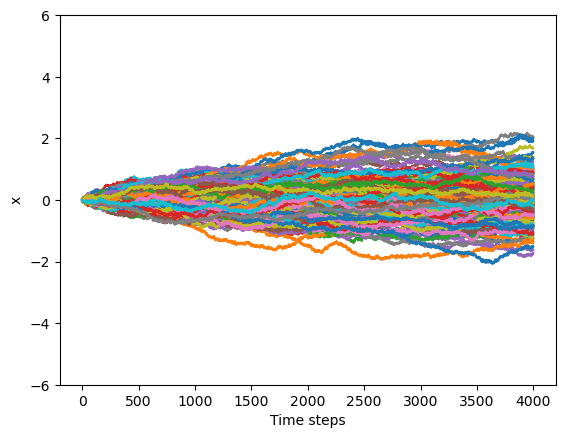

In [5]:
# Checking the drifts in diffrent samples in case 0

for y in all_result[:,0,:]:
    plt.plot(y)
plt.xlabel("Time steps")
plt.ylabel("x")

plt.ylim(-6,6)

(-6.0, 6.0)

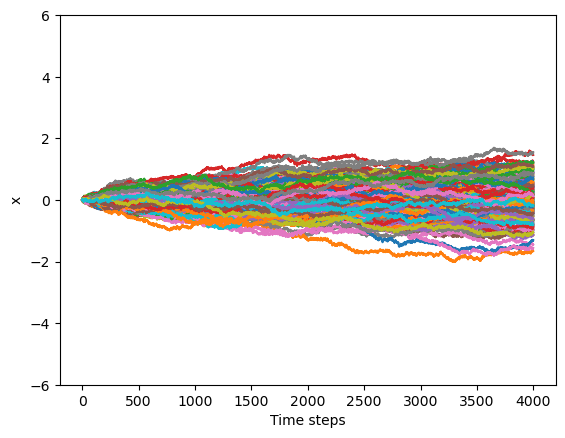

In [6]:
# Checking the drifts in diffrent samples in case 1

for y in all_result[:,1,:]:
    plt.plot(y)
plt.xlabel("Time steps")
plt.ylabel("x")
plt.ylim(-6,6)

#### Measuring the drift

To measure the drift, we plot the mean-square of the drifted displacement. In the following calculation, we square the displacement and take the mean across samples. The formula is 

\begin{equation}
X(t)^2 = \frac{\sum_i x_i(t)^2}{N_{sample}}
\end{equation}

This is effectively the following python code.

In [7]:
# Calculate the mean square

case_0_var = np.mean(np.square(all_result[:,0,:]), axis=0)
case_1_var = np.mean(np.square(all_result[:,1,:]), axis=0)

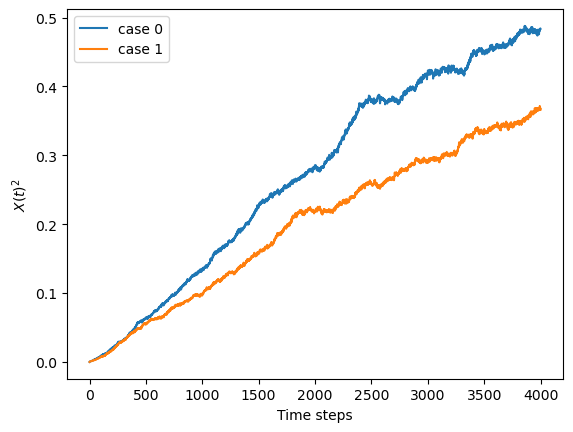

In [8]:
# Plotting the mean square

plt.plot(case_0_var, label="case 0")
plt.plot(case_1_var, label="case 1")
plt.xlabel("Time steps")
plt.ylabel("$X(t)^2$")
plt.legend()

#### Measuring the Diffusion Constant 

Diffusion contsant is also a concept in Brownian motion. In one-dimensional case, the mean square of displacement is directly proportional to time, i.e.,

\begin{equation}
X(t) = 2D t .
\end{equation}

Details can be found in https://en.wikipedia.org/wiki/Brownian_motion. 

By the above result, the diffusion in case 0 is different from that of case 1. I want to see **the difference between slopes (the diffusion constants) in differnt cases, $k$, and $\beta$.** You can use a scipy function to calculate the slope to obtain the diffusion constant. The usage can be found in https://www.w3schools.com/python/python_ml_linear_regression.asp.

You may try different $k$ and $\beta$. After that, you can try a for loop to generate results for a range of $k$ and $\beta$.


In [9]:
np.savez_compressed("03_results_out.npz", results=all_result)